In [91]:
import numpy as np
import torch
import math
import pandas as pd
import copy 
from typing import Optional
from torch import Tensor
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import random
import warnings
from matplotlib import pyplot as plt
warnings.filterwarnings("ignore")

#Botorch imports
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition.analytic import LogExpectedImprovement, LogProbabilityOfImprovement, UpperConfidenceBound
# from botorch.acquisition.monte_carlo import qLowerConfidenceBound
from gpytorch.kernels import MaternKernel, RBFKernel, ScaleKernel

from sklearn.ensemble import RandomForestRegressor
from botorch.models.ensemble import EnsembleModel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [92]:
class EnsembleRandomForestModel(EnsembleModel):
    model: RandomForestRegressor
    num_samples: int
    _num_outputs: int

    def __init__(self, num_samples: int = 100):
        super(EnsembleRandomForestModel, self).__init__()
        self._num_outputs = 1
        self.model = RandomForestRegressor(n_estimators=num_samples, bootstrap=True)

    def fit(self, X: Tensor, y: Tensor) -> None:
        self.model = self.model.fit(
            X=X.detach().numpy(), y=y.detach().numpy().squeeze()
        )

    def forward(self, X: Tensor) -> Tensor:
        x = X.squeeze(0)
        # Create the ensemble from predictions from each decision tree.
        y = torch.from_numpy(np.array([i.predict(x) for i in self.model.estimators_]))
        # `EnsemblePosterior` expects a `(b) x s x q x m` tensor where `m` is the
        # output size of the model and `s` is the ensemble size.
        samples = y.transpose(0, 1).reshape(X.shape[0], -1, 1, self.num_outputs)
        return samples

In [93]:
def prepare_data(dataset_path):
    raw_dataset = pd.read_csv(dataset_path + '_dataset.csv')
    feature_name = list(raw_dataset.columns)[:-1]
    objective_name = list(raw_dataset.columns)[-1]
    
    ds = copy.deepcopy(raw_dataset) 
    # ds[objective_name] = -raw_dataset[objective_name].values #turn the problem into a minimization problem 
    
    #drop duplicates and missing values
    ds_grouped = ds.groupby(feature_name)[objective_name].agg(lambda x: x.unique().mean())
    ds_grouped = (ds_grouped.to_frame()).reset_index()
    ds_grouped.dropna(inplace=True) 
    
    
    X_feature = ds_grouped[feature_name].values
    y = np.array(ds_grouped[objective_name].values)

    assert len(ds_grouped) == len(X_feature) == len(y)
    
    pca = PCA(n_components=2)
    scalar = StandardScaler()
    
    X_PCA = pca.fit_transform(scalar.fit_transform(X_feature))
    kmeans = KMeans(n_clusters=2, random_state=0).fit(X_PCA)
    
    ds_grouped['cluster'] = kmeans.labels_
    
    # Scatter plot for each cluster
    for cluster_label in np.unique(kmeans.labels_):
        plt.scatter(
            X_PCA[kmeans.labels_ == cluster_label, 0], 
            X_PCA[kmeans.labels_ == cluster_label, 1], 
            s=10, 
            label=f'Cluster {cluster_label}'
        )

    # Add title, axis labels, and legend
    plt.title('KMeans Clustering')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.show()
    
    N = len(ds_grouped)
    
    return X_feature, y, N, feature_name, objective_name, ds_grouped
    

In [95]:
def initialization(data, n_init, cluster_num):
    cluster = data[data['cluster'] == cluster_num]
    #random initialization
    indices = cluster.index.tolist()
    return random.sample(indices, n_init)

In [84]:
def pool_learning(X, y, N, acqui_fn, top_indices, n_initial,seed):
    device = torch.device("cpu")
    print("Using device: ", device)
    np.random.seed(seed)
    
    
    indices_to_learn = [i for i in range(len(X))] # indices that are still in the pool
    indices_learned= [] # indices that have been learned
    train_indices = random.sample(range(N), n_initial) # start with n_initial random points
    
    train_obj = torch.from_numpy(y[train_indices]).unsqueeze(-1).float() # objective values of these points
    train_x = torch.from_numpy(X[train_indices]).float() # input features of these points
    
    for i in train_indices:
        indices_to_learn.remove(i) # remove these points from the pool
    
    indices_learned.extend(train_indices) # add these points to learned points
    
    cnt = 0 #this counts the number of times the top indices are learned
    
    top_indices_cnt = []
    for index in indices_learned:
        if index in top_indices:
            cnt += 1
        top_indices_cnt.append(cnt)
                
    i = 0
    while len(indices_learned) < len(X):
        # initialize the model and fit it
        train_x = train_x.to(device)
        train_obj = train_obj.to(device)
        assert len(train_x) == len(train_obj)
        RF_model = EnsembleRandomForestModel(num_samples=100)
        RF_model.fit(train_x, train_obj)
        
        # apply the acquisition function
        best_value = train_obj.max()
        acqui = acqui_fn(model=RF_model, best_f = best_value).to(device)
        
        # Apply acquisition function to find the best index to learn next
        candidate_features = torch.from_numpy(X[indices_to_learn]).float().to(device)
        acq_values = np.array([acqui(i.unsqueeze(0)).detach().numpy() for i in candidate_features])
        print(i, "th iteration")
        i += 1
        # print(acq_values)
        next_index = indices_to_learn[np.argmax(acq_values)] # find the index with the highest acquisition value
        
        
        # add the new point to the training set
        train_indices.append(next_index)
        indices_to_learn.remove(next_index)
        indices_learned.append(next_index)
        
        # update the training set
        train_x = torch.from_numpy(X[train_indices]).float()
        train_obj = torch.from_numpy(y[train_indices]).unsqueeze(-1).float()
        
        #update record of top indices
        if next_index in top_indices:
            cnt += 1
        
        top_indices_cnt.append(cnt)
        if cnt == len(top_indices):
            break
        
        
    return indices_learned, top_indices_cnt
    

### Select hyperparameters

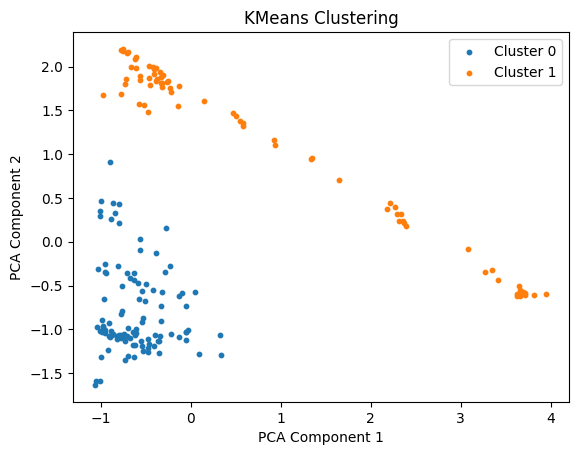

     P3HT content (%)  D1 content (%)  D2 content (%)  D6 content (%)  \
0               15.00            0.00            0.00           85.00   
1               16.15            0.46           25.38           51.42   
2               16.88            1.25           24.96           49.58   
3               17.71            0.98           25.34           50.30   
4               18.67            0.27           47.09           24.03   
..                ...             ...             ...             ...   
173             93.87            0.24            0.56            0.24   
174             94.58            0.03            1.15            1.38   
175             94.81            0.30            0.28            0.08   
176             95.00            0.00            0.00            0.00   
177             96.27            0.27            2.02            0.85   

     D8 content (%)  Conductivity (measured) (S/cm)  cluster  
0              0.00                          45.970        1

In [85]:
dataset = './datasets/P3HT' # Chanage the name of the dataset in the end of the path

#Benchmarking Parameters
# number of ensembles. in the paper n_ensemble = 50.
X_feature, y, N, feature_name, objective_name, ds_grouped = prepare_data(dataset)
print(ds_grouped)
n_ensemble = 50
# number of initial experiments
n_initial = 2
# number of top candidates, currently using top 5% of total dataset size
n_top = int(math.ceil(len(y) * 0.05))
# the top candidates and their indicies
top_indices = list(ds_grouped.sort_values(objective_name).head(n_top).index)

# random seeds used to distinguish between different ensembles
# there are 300 of them, but only first n_ensemble are used
seed_list = [4295, 8508, 326, 3135, 1549, 2528, 1274, 6545, 5971, 6269, 2422, 4287, 9320, 4932, 951, 4304, 1745, 5956, 7620, 4545, 6003, 9885, 5548, 9477, 30, 8992, 7559, 5034, 9071, 6437, 3389, 9816, 8617, 3712, 3626, 1660, 3309, 2427, 9872, 938, 5156, 7409, 7672, 3411, 3559, 9966, 7331, 8273, 8484, 5127, 2260, 6054, 5205, 311, 6056, 9456, 928, 6424, 7438, 8701, 8634, 4002, 6634, 8102, 8503, 1540, 9254, 7972, 7737, 3410, 4052, 8640, 9659, 8093, 7076, 7268, 2046, 7492, 3103, 3034, 7874, 5438, 4297, 291, 5436, 9021, 3711, 7837, 9188, 2036, 8013, 6188, 3734, 187, 1438, 1061, 674, 777, 7231, 7096, 3360, 4278, 5817, 5514, 3442, 6805, 6750, 8548, 9751, 3526, 9969, 8979, 1526, 1551, 2058, 6325, 1237, 5917, 5821, 9946, 5049, 654, 7750, 5149, 3545, 9165, 2837, 5621, 6501, 595, 3181, 1747, 4405, 4480, 4282, 9262, 6219, 3960, 4999, 1495, 6007, 9642, 3902, 3133, 1085, 3278, 1104, 5939, 7153, 971, 8733, 3785, 9056, 2020, 7249, 5021, 3384, 8740, 4593, 7869, 9941, 8813, 3688, 8139, 6436, 3742, 5503, 1587, 4766, 9846, 9117, 7001, 4853, 9346, 4927, 8480, 5298, 4753, 1151, 9768, 5405, 6196, 5721, 3419, 8090, 8166, 7834, 1480, 1150, 9002, 1134, 2237, 3995, 2029, 5336, 7050, 6857, 8794, 1754, 1184, 3558, 658, 6804, 8750, 5088, 1136, 626, 8462, 5203, 3196, 979, 7419, 1162, 5451, 6492, 1562, 8145, 8937, 8764, 4174, 7639, 8902, 7003, 765, 1554, 6135, 1689, 9530, 1398, 2273, 7925, 5948, 1036, 868, 4617, 1203, 7680, 7, 93, 3128, 5694, 6979, 7136, 8084, 5770, 9301, 1599, 737, 7018, 3774, 9843, 2296, 2287, 9875, 2349, 2469, 8941, 4973, 3798, 54, 2938, 4665, 3942, 3951, 9400, 3094, 2248, 3376, 1926, 5180, 1773, 3681, 1808, 350, 6669, 826, 539, 5313, 6193, 5752, 9370, 2782, 8399, 4881, 3166, 4906, 5829, 4827, 29, 6899, 9012, 6986, 4175, 1035, 8320, 7802, 3777, 6340, 7798, 7705]

In [86]:
results = []

for i in tqdm(range(n_ensemble)):
    acqui_fn = LogExpectedImprovement
    print(f"Running ensemble {i+1} : {acqui_fn.__name__}")

    indices, top_indices_cnt = pool_learning(
        X=X_feature,
        y=y,
        acqui_fn=acqui_fn,
        top_indices=top_indices,
        n_initial=n_initial,
        N = N,
        seed=seed_list[3]
    )
    results.append(top_indices_cnt)

  0%|          | 0/50 [00:00<?, ?it/s]

Running ensemble 1 : LogExpectedImprovement
Using device:  cpu


  0%|          | 0/50 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [7]:
saved = np.array(results, dtype=object)
print(saved)
np.save('results_P3HT_RF_EI.npy', saved)

[list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 8, 9])
 list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6